In [24]:
import os
import geopandas as gpd
from pathlib import Path
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import box
from rasterio.mask import mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LABEL_TEXT_MATCHING = {
    "1": "Acropora Branching", 
    "2": "Non-acropora Massive",
    "3": "Other Corals",
    "4": "Sand",
    "5": "Syringodium",
}
COLOR_MAP = {
    "Acropora Branching": "rgba(0, 153, 255, 127)",
    "Non-acropora Massive": "rgba(204, 102, 0, 127)",
    "Other Corals": "rgba(204, 0, 204, 127)",
    "Sand": "rgba(255, 204, 51, 127)",
    "Syringodium": "rgba(0, 204, 102, 127)"
}

title = {
    "langue_sable": "Rubble evolution",
    "syringodium": "Syringodium extinction",
}

# Convert CSS rgba to matplotlib-compatible
def rgba_to_mpl(rgba_str):
    rgba_str = rgba_str.replace("rgba(", "").replace(")", "")
    r, g, b, a = map(float, rgba_str.split(", "))
    return (r/255, g/255, b/255)


folder_of_geojson_to_compare = Path("./zones_ign")

list_raster  = list(Path("../../data/pred_ign/2017").iterdir()) + list(Path("../../data/pred_ign/2022").iterdir())

In [27]:
def intersect(raster_path, gdf):
    with rasterio.open(raster_path) as src:
        # Get raster bounds as shapely polygon
        raster_bounds = box(*src.bounds)
        raster_crs = src.crs

        # Reproject GeoJSON geometries to raster CRS
        gdf_proj = gdf.to_crs(raster_crs)

        # Check intersection
        intersects = gdf_proj.intersects(raster_bounds).any()

        return intersects

def extract_data(raster_path, gdf):
    year = raster_path.name.split("-")[1]
    records = []
    with rasterio.open(raster_path) as src:
        gdf_proj = gdf.to_crs(src.crs)
        try:
            out_image, _ = mask(src, gdf_proj.geometry, crop=True, nodata=src.nodata)
        except ValueError:
            print(f"⚠️ No overlap for {raster_path}")
            return

        data = out_image[0]
        if src.nodata is not None:
            data = data[data != src.nodata]

        unique, counts = np.unique(data, return_counts=True)
        for cls, cnt in zip(unique, counts):
            label = LABEL_TEXT_MATCHING.get(str(int(cls)), f"Class {cls}")
            records.append({"year": year, "class": label, "count": int(cnt)})
    return records

def plot_stack_graph(records, geojson_name, years):

    # === MAKE DATAFRAME ===
    df = pd.DataFrame(records)

    # === Normalize to percentages (optional) ===
    df["percent"] = df.groupby("year")["count"].transform(lambda x: x / x.sum() * 100)
    # === PLOT ===
    fig, ax = plt.subplots(figsize=(8, 6))

    # Sort classes in defined order
    class_order = list(LABEL_TEXT_MATCHING.values())

    bottoms = {year: 0 for year in years}

    for coral_class in class_order:
        colors = rgba_to_mpl(COLOR_MAP[coral_class])
        for year in years:
            val = df[(df["year"] == year) & (df["class"] == coral_class)]["percent"].sum()
            ax.bar(year, val, bottom=bottoms[year], color=colors, label=coral_class if year == list(years)[0] else "")
            bottoms[year] += val

    ax.set_ylabel("Percentage of Pixels (%)")
    ax.set_title(title.get(geojson_name) + " - IGN 2017/2022")
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(f'{geojson_name}.png', bbox_inches='tight' )
    plt.show()

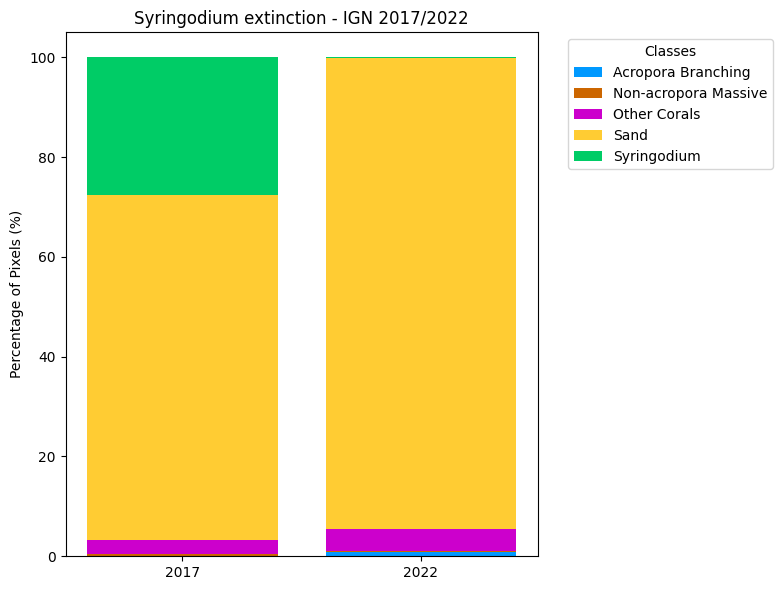

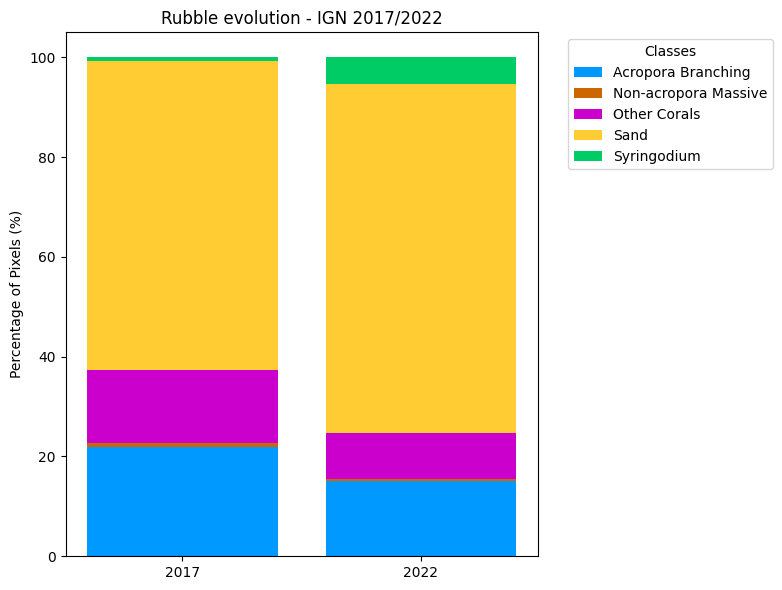

In [28]:

for geojson in folder_of_geojson_to_compare.iterdir():
    if geojson.suffix.lower() not in [".geojson"]: continue
    gdf = gpd.read_file(geojson)
    
    records, years = [], []
    toshow = []
    for file in list_raster:
        if file.suffix.lower() != ".tif": continue
        if "preddata" not in file.name: continue

        if not intersect(file, gdf):
            continue
        record =  extract_data(file, gdf)
        if len(record) == 0: continue

        
        year = file.name.split("-")[1]
        years.append(year)
        
        records += record
    
    plot_stack_graph(records, geojson.stem, years)
